### Tikhvinskiy_136782149, cкор на Kaggle 0.96280

# Путешествие по Спрингфилду.

 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Apr 26 15:23:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
from collections import defaultdict
import copy
import pickle
import numpy as np
import random
from skimage import io

from tqdm import tqdm_notebook
from tqdm.auto import tqdm
from PIL import Image
from pathlib import Path


from torchvision import models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q gdrive/MyDrive/journey-springfield.zip
!ls train

simpsons_dataset


In [ ]:
SEED = 1400

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
# для преобразования картинок к квадратному виду
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return transforms.functional.pad(image, padding, 0, 'constant')

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train': 
            transform = transforms.Compose([
#                 SquarePad(),
#                 transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.CenterCrop(200),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
#                 SquarePad(),
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.CenterCrop(200),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))


In [ ]:
# разобьем данные на тренировочные и валидационные
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# добавим картинок к классам где их недостаточно
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = defaultdict(lambda: [])
    for path_i, label_i in zip(train_files, train_labels):
       dct_simpsons[label_i].append(path_i)
    return dct_simpsons

# cоздадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(sorted(train_files), train_dataset.labels)

# дополним до нужной цифры количество картинок если их недостаточно в классе
num_pics = 120  
for person in dct_path_train:
    if len(dct_path_train[person]) < num_pics:
        dct_path_train[person] = dct_path_train[person] * (num_pics // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:num_pics - len(dct_path_train[person])])

# проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

abraham_grampa_simpson	685
agnes_skinner	120
apu_nahasapeemapetilon	467
barney_gumble	120
bart_simpson	1006
carl_carlson	120
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	120
comic_book_guy	352
disco_stu	120
edna_krabappel	343
fat_tony	120
gil	120
groundskeeper_willie	120
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	120
lisa_simpson	1015
maggie_simpson	120
marge_simpson	968
martin_prince	120
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	120
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	120
patty_bouvier	120
principal_skinner	895
professor_john_frink	120
rainier_wolfcastle	120
ralph_wiggum	120
selma_bouvier	120
sideshow_bob	658
sideshow_mel	120
snake_jailbird	120
troy_mcclure	120
waylon_smithers	136


In [ ]:
# проверяем сколько прибавилось и каких картинок
import pandas as pd 

n = pd.Series(new_train_files).value_counts()
print('Прибавилось картинок',  n[n > 1].sum() - len(n[n > 1]), '\n')
n[n > 1]

Прибавилось картинок 1616 



train/simpsons_dataset/lionel_hutz/pic_0001.jpg             60
train/simpsons_dataset/lionel_hutz/pic_0000.jpg             60
train/simpsons_dataset/troy_mcclure/pic_0004.jpg            20
train/simpsons_dataset/disco_stu/pic_0003.jpg               20
train/simpsons_dataset/troy_mcclure/pic_0000.jpg            20
                                                            ..
train/simpsons_dataset/carl_carlson/pic_0016.jpg             2
train/simpsons_dataset/patty_bouvier/pic_0039.jpg            2
train/simpsons_dataset/groundskeeper_willie/pic_0032.jpg     2
train/simpsons_dataset/martin_prince/pic_0035.jpg            2
train/simpsons_dataset/barney_gumble/pic_0044.jpg            2
Length: 654, dtype: int64

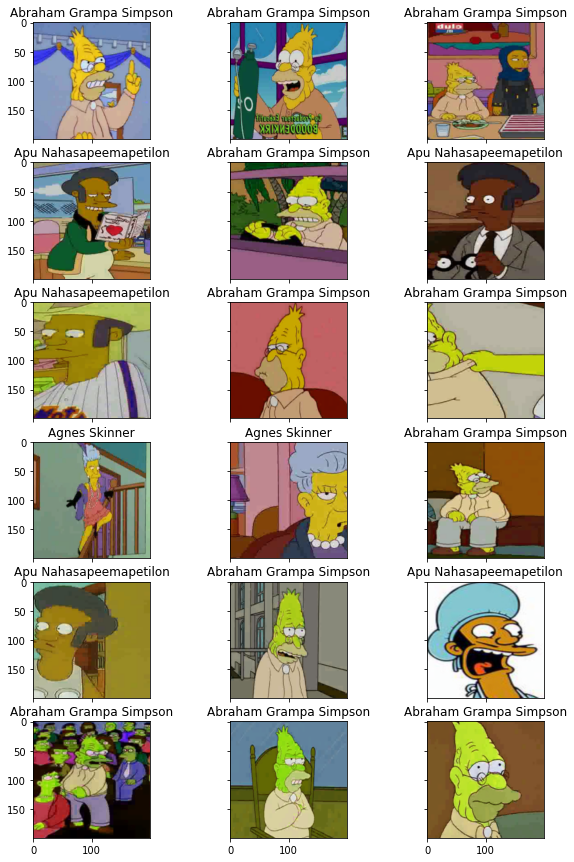

In [ ]:
# смотрим на картинки после преобразований на которых будем обучаться
fig, ax = plt.subplots(nrows=6, ncols=3,figsize=(10, 15), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = new_train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

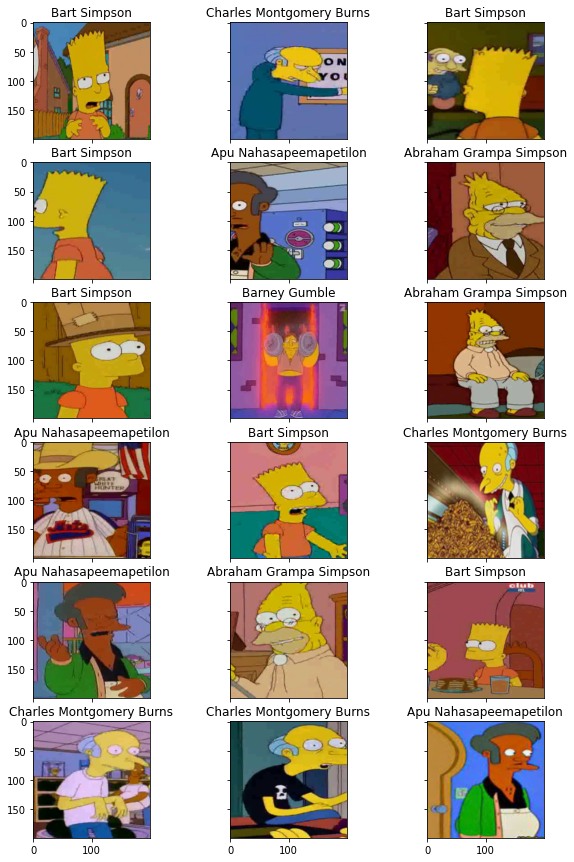

In [ ]:
# картинки на которых валидируемся
fig, ax = plt.subplots(nrows=6, ncols=3,figsize=(10, 15), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
# функции для работы нейронной сети
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_dataset, val_dataset, model, epochs, batch_size, shuffle=True, sampler=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 3, 0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
# воспользуемся сверточной нейронной сетью Resnet18 
model_resnet = models.resnet18(pretrained=True).to(DEVICE)

# посмотрим на ее устройство
child_counter = 0
for child in model_resnet.children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



 child 0 is:
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
 child 1 is:
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 child 2 is:
ReLU(inplace=True)
 child 3 is:
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 child 4 is:
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(6

In [ ]:
# обучать будем только последний слой
for i, child in enumerate(model_resnet.children()):
    if i not in [9]:
        for param in child.parameters():
            param.requires_grad = False

# изменим последний слой тк нам нужно классифицировать на 42 класса
model_resnet.fc = nn.Sequential(nn.Linear(512,42))

In [ ]:
model_resnet = model_resnet.cuda()

In [ ]:
# обучим предварительно обученную модель
history = train(new_train_dataset, val_dataset, model=model_resnet, epochs=2, 
                batch_size=64)

loss 2.4372874784979075

Epoch 001 train_loss: 2.4373     val_loss 1.6627 train_acc 0.4025 val_acc 0.6091
loss 1.5381814647677865

Epoch 002 train_loss: 1.5382     val_loss 1.3374 train_acc 0.6211 val_acc 0.6710



In [ ]:
# видим, что получившееся качество на валидации не высокое

In [ ]:
# функция для предсказания класса отдельной картинки
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
# посмотрим как распознались картинки на валидации, функция выводит где сеть ошибается
def incorrect_view(n=10):
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    files_of_picts = sorted(val_files)
    bad = 0
    print(f'Incorrect predictions, show one of {n}: \n')
    for i in range(len(val_dataset)):
        class_of_pict = val_dataset[i][1]
        img_label = val_dataset.label_encoder.inverse_transform([class_of_pict])[0] 
        pict = val_dataset[i][0]
        prob_pred = predict_one_sample(model_resnet, pict.unsqueeze(0))
        predicted_proba = np.max(prob_pred) * 100
        y_pred = np.argmax(prob_pred)
        right = (y_pred == class_of_pict)
        if not right:
            bad += 1
            if bad % n == 0:
                print(f'Real: {img_label} \nPredicted with {predicted_proba:.0f}%: {label_encoder.classes_[y_pred]} \nFile: {files_of_picts[i]}')
                imshow(pict)
                plt.show()

In [ ]:
# видим модель сильно ошибается
incorrect_view()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# теперь обучим всю сеть, включим все слои
for child in model_resnet.children():
    for param in child.parameters():
        param.requires_grad = True

In [ ]:
# увеличим число эпох до 25
history = train(new_train_dataset, val_dataset, model=model_resnet, epochs=25, batch_size=64)

loss 3.941380728981311

Epoch 001 train_loss: 3.9414     val_loss 3.1681 train_acc 0.0940 val_acc 0.1074
loss 3.3361758471705683

Epoch 002 train_loss: 3.3362     val_loss 3.1581 train_acc 0.0972 val_acc 0.1074
loss 3.214250144826309

Epoch 003 train_loss: 3.2143     val_loss 2.7872 train_acc 0.1239 val_acc 0.1983
loss 2.7051682686895226

Epoch 004 train_loss: 2.7052     val_loss 2.3297 train_acc 0.2610 val_acc 0.3447
loss 2.2430205735656314

Epoch 005 train_loss: 2.2430     val_loss 1.7952 train_acc 0.3823 val_acc 0.4977
loss 1.7424439198083352

Epoch 006 train_loss: 1.7424     val_loss 1.4502 train_acc 0.5144 val_acc 0.5942
loss 1.2164163367823304

Epoch 007 train_loss: 1.2164     val_loss 1.2195 train_acc 0.6572 val_acc 0.6760
loss 0.9817231788891366

Epoch 008 train_loss: 0.9817     val_loss 0.9930 train_acc 0.7219 val_acc 0.7384
loss 0.7876729020107147

Epoch 009 train_loss: 0.7877     val_loss 0.9699 train_acc 0.7760 val_acc 0.7390
loss 0.5712836583501302

Epoch 010 train_loss: 0

In [ ]:
# сохранить веса нашей нейросети
# model_resnet18_25 = copy.deepcopy(model_resnet.state_dict())
# torch.save(model_resnet18_25, "gdrive/MyDrive/springfield_data/model_resnet18_25.pth")

In [ ]:
# загружаем сохраненное состояние весов нейросети
# model_resnet.load_state_dict(torch.load("gdrive/MyDrive/springfield_data/model_resnet18_25.pth"))

In [ ]:
# модель заметно прибавила в качестве, посмотрим где она ошиблась
incorrect_view(1)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# посмотрим на получившиеся метрики качества
loss, acc, val_loss, val_acc = zip(*history)

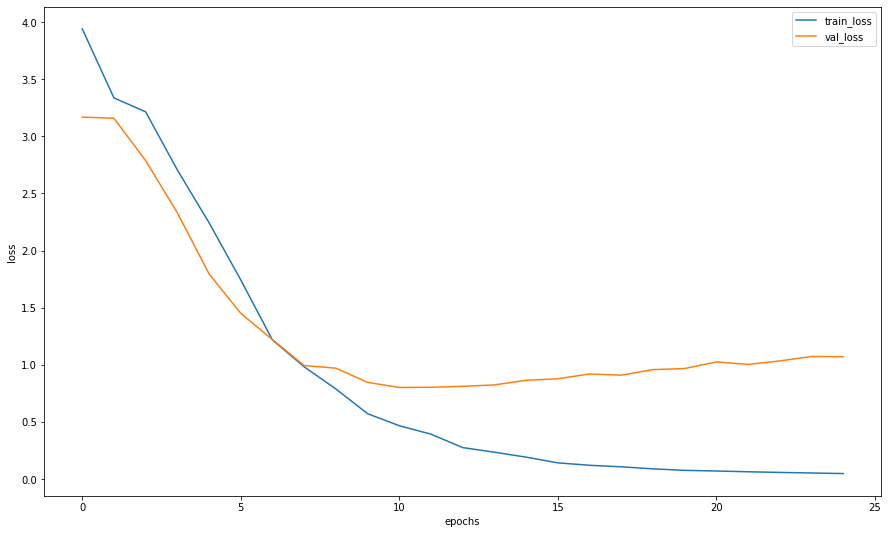

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_resnet, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_resnet, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
# посчитаем метрику f1
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.8000000000000002

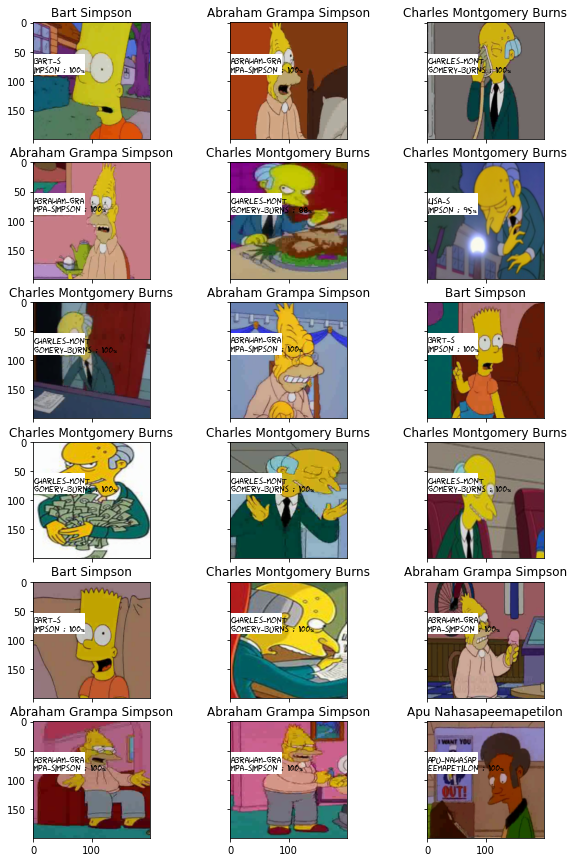

In [ ]:
# посмотрим на случайную выборку картинок на валидации
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=6, ncols=3,figsize=(10, 15), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_resnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
# отправим результат на Kaggle
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_resnet, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
mysubmit = pd.DataFrame(columns=['Id'])
test_filenames = [path.name for path in test_dataset.files]
mysubmit['Id'] = test_filenames

In [ ]:
mysubmit[f'Expected'] = preds
mysubmit.to_csv('resnet18_25.csv', index=False)

In [ ]:
# Keggle cкор 0.96280